# Analysis of the MovieLens Dataset

## Important notebook instructions:
Libraries we have used in the notebook

In [8]:
import pandas as pd
import numpy as np

# For API
import os
import json
import requests

# For images / charts / graphs / plots
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import seaborn as sns

# Libraries used for Linear Regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Libraries Used for Recommender System
import os
import warnings
import numpy as np
import pandas as pd
from math import sqrt
from sklearn.feature_extraction.text import TfidfVectorizer
from itertools import combinations
from sklearn.metrics.pairwise import pairwise_distances,cosine_similarity
warnings.filterwarnings('ignore')


## 1. Introduction

As any other day me and my friends sat down for our ritualistic weekend movie marathon where we were confronted with the classic conundrum that haunts the routine “Netflix and Chill” plans of all couch potatoes - deciding on which movie to watch. Each member of our eclectic bunch had our own unique taste in films, from heart pounding thrillers to heartwarming dramas, and thus, inevitably, ensued conflicts and debates; that is until we decided to use the MovieLens software as a game changing solution for our movie night dilemma. Little did we know that this would turn out to be a night of data-driven cinematic exploration than ones filled with endless refills of the popcorn bowl.

The discussion initially played out as a quest for a highly rated movie. While one of us was adamant that romantic comedies were the golden ticket to high ratings, another staunchly argued that adventure movies were the ultimate crowd pleasers. It was a clash of genres, and we needed a verdict. Turning to the software, we set out to decipher this and with a few clicks and some eager anticipation, the data spoke for itself. The linear regression model unveiled the truth behind the ratings, revealing that, contrary to expectations, it wasn't just about rom coms or adventure – it was about finding that sweet spot where genres intersected with audience preferences.

As we ventured into the realms of user ratings, genres, and connections between movies, a powerful tool emerged – the recommender system, fueled by the concept of cosine similarity. It was like a personalized roadmap leading each of us to movies that resonated with our individual tastes. With a little technological magic, our movie nights were about to undergo a transformation and they would never be the same again.

This notebook explores the MovieLens dataset, diving into movie data to uncover patterns and reshape our cinematic experiences.

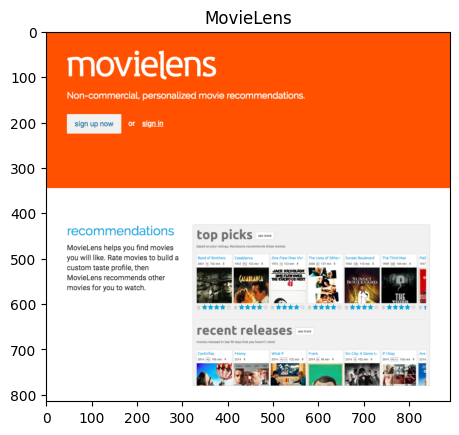

In [9]:
plt.title("MovieLens")

image = mpimg.imread("movielens.png")
plt.imshow(image)
plt.show()

## 2. Research Questions / Objectives
### A. Research Question
1. How do different movie genres and other different variables influence user ratings in the MovieLens dataset?
2. How effective is cosine similarity in understanding the similarity of movies based on their genres and can we use this to build a recommender system?

### B. Objective
1. Develop a predictive model based on linear regression to estimate user ratings for movies based on genres and other different features.
2. Implement a movie recommender system using genre information and cosine similarity scores to provide movie suggestions.

## 3. Dataset

We use the MovieLens dataset, which is a dataset which contains a set of movie ratings from the MovieLens website, which is a recommendation service. This dataset was collected and maintained by GroupLens, a research group at the University of Minnesota.

For the purpose of this analysis, we use the 'latest-small' dataset which is a small subset of the latest version of the MovieLens dataset. This dataset contains 4 files - movies.csv, ratings.csv, links.csv and tags.csv.

1. 'latest-small-movies' - This contains data of 9742 movies rated in the latest-small dataset.
2. 'latest-small-ratings' - This dataset contains 100,836 ratings across 9,742 movies, created by 610 users between March 29, 1996 and September 24, 2018. This dataset does not include demographic data.
3. 'latest-small-links' - This dataset contains the imdbId and the tmdbId for each movieId in the movies dataset.


In [10]:
# We save all the csv files as DataFrames

In [11]:
movies = pd.read_csv("ml-latest-small/movies.csv")
ratings = pd.read_csv("ml-latest-small/ratings.csv")
links = pd.read_csv("ml-latest-small/links.csv")
# tags = pd.read_csv("ml-latest-small/tags.csv")

In [12]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [13]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [14]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


We wanted to explore more about the movies using the links file and we wanted to extract some more information using the IMDB or TMDB ID's provided in the file. We decided to use the tmdbId to extract some more features about the movie using the TMDB API.

Since there are Movies and TV Series, we are checking whether the given tmdbId is a movie or a tv_series, hence we use try-except to avoid any errors. We extract the Name of the Movie, the Budget, Revenue, Original Language of the Movie and the Runtime. We also wanted to explore more information regarding the movies like Actors and Directors and we use the API from the TMDB to extract the credits of movies and tv series.
For the API and Extraction to work it takes approximately 4-5 hours at the end of which we create a dataframe movie_details containing all the information and store this data in a CSV file.

In [15]:
links = links.dropna(subset = ['tmdbId'])
len(links)

9741

In [16]:
# DataFrame to store all the data extracted from the API
movie_details = pd.DataFrame(links['tmdbId'].astype(int))

In [17]:
# API Key from the tmbd website
api_key = 'ef56f0e1c3170ada9b63414950fb6dfd'
# print(api_key)

# URL for the API
url_movie = "https://api.themoviedb.org/3/movie/"  # URL for movies
url_tv = "https://api.themoviedb.org/3/tv/"        # URL for tv_series

j = 0

In [18]:
for i in movie_details['tmdbId']:
    tmdbid = i
    j = j + 1
    print(j, '-', tmdbid)

    resmovie = requests.get(url_movie + str(tmdbid) + "?api_key=" + api_key)  # extracts movie details as json file for particular movie
    rescredits = requests.get(url_movie + str(tmdbid) + "/credits?api_key=" + api_key) # extracts movie credits as json file for each movie

    try:
        # Try to get 'success' key from JSON response resmovie
        suc_val = resmovie.json()['success']  # the 'success' key is generated as 'False' in JSON response only if there is no movie data generated for the ID

    except:     # Executed if some error is detected while checking for 'success' key
        # If an error occurs, we treat it as a movie
        movie_details.loc[movie_details['tmdbId'] == tmdbid, 'type'] = 'movie'

        movie_details.loc[movie_details['tmdbId'] == tmdbid, 'Name'] = resmovie.json()['title']
        movie_details.loc[movie_details['tmdbId'] == tmdbid, 'Budget'] = resmovie.json()['budget']
        movie_details.loc[movie_details['tmdbId'] == tmdbid, 'Revenue'] = resmovie.json()['revenue']
        movie_details.loc[movie_details['tmdbId'] == tmdbid, 'Original_Lang'] = resmovie.json()['original_language']
        movie_details.loc[movie_details['tmdbId'] == tmdbid, 'Runtime'] = resmovie.json()['runtime']
        movie_details.loc[movie_details['tmdbId'] == tmdbid, 'Episodes'] = 0
        movie_details.loc[movie_details['tmdbId'] == tmdbid, 'Adult'] = resmovie.json()['adult']

        try:
            movie_details.loc[movie_details['tmdbId'] == tmdbid, 'Actor_1'] = rescredits.json()['cast'][0]['name']

        except:
            movie_details.loc[movie_details['tmdbId'] == tmdbid, 'Actor_1'] = 'No Actor'

        try:
            movie_details.loc[movie_details['tmdbId'] == tmdbid, 'Actor_2'] = rescredits.json()['cast'][1]['name']

        except:
            movie_details.loc[movie_details['tmdbId'] == tmdbid, 'Actor_2'] = 'No Actor'

        try:
            movie_details.loc[movie_details['tmdbId'] == tmdbid, 'Director'] = [person['name'] for person in rescredits.json()['crew'] if person.get('job') == 'Director'] # to get director name

        except:
            movie_details.loc[movie_details['tmdbId'] == tmdbid, 'Director'] = 'No Director'


    else:  # Executed if no error is detected while checking for 'success' key
        # If success key is present and its value is 'False', we treat it as a tv_series
        if suc_val == 'False':
            restv = requests.get(url_tv + str(tmdbid) + "?api_key=" + api_key)
            restvcred = requests.get(url_tv + str(tmdbid) + "/credits?api_key=" + api_key)
            movie_details.loc[movie_details['tmdbId'] == tmdbid, 'type'] = 'tv_series'

            movie_details.loc[movie_details['tmdbId'] == tmdbid, 'Name'] = restv.json()['name']
            movie_details.loc[movie_details['tmdbId'] == tmdbid, 'Budget'] = 0
            movie_details.loc[movie_details['tmdbId'] == tmdbid, 'Revenue'] = 0
            movie_details.loc[movie_details['tmdbId'] == tmdbid, 'Original_Lang'] = restv.json()['original_language']
            movie_details.loc[movie_details['tmdbId'] == tmdbid, 'Runtime'] = restv.json()['episode_run_time'][0]
            movie_details.loc[movie_details['tmdbId'] == tmdbid, 'Episodes'] = restv.json()['number_of_episodes']
            movie_details.loc[movie_details['tmdbId'] == tmdbid, 'Adult'] = restv.json()['adult']

            try:
                movie_details.loc[movie_details['tmdbId'] == tmdbid, 'Actor_1'] = restvcred.json()['cast'][0]['name']

            except:
                movie_details.loc[movie_details['tmdbId'] == tmdbid, 'Actor_1'] = 'No Actor'

            try:
                movie_details.loc[movie_details['tmdbId'] == tmdbid, 'Actor_2'] = restvcred.json()['cast'][1]['name']

            except:
                movie_details.loc[movie_details['tmdbId'] == tmdbid, 'Actor_2'] = 'No Actor'

            try:
                movie_details.loc[movie_details['tmdbId'] == tmdbid, 'Director'] = restv.json()['created_by'][0]['name']

            except:
                movie_details.loc[movie_details['tmdbId'] == tmdbid, 'Director'] = 'No Director'


In [19]:
# movie_details.to_csv("movie_details.csv")
movie_details = pd.read_csv("ml-latest-small/movie_details.csv")
movie_details.head()

,tmdbId,type,Name,Budget,Revenue,Original_Lang,Runtime,Adult,Actor_1,Actor_2,Director
0,862,movie,Toy Story,30000000.0,394400000.0,en,81.0,False,Tom Hanks,Tim Allen,John Lasseter
1,8844,movie,Jumanji,65000000.0,262821940.0,en,104.0,False,Robin Williams,Kirsten Dunst,Joe Johnston
2,15602,movie,Grumpier Old Men,25000000.0,71500000.0,en,101.0,False,Walter Matthau,Jack Lemmon,Howard Deutch
3,31357,movie,Waiting to Exhale,16000000.0,81452156.0,en,127.0,False,Whitney Houston,Angela Bassett,Forest Whitaker
4,11862,movie,Father of the Bride Part II,0.0,76594107.0,en,106.0,False,Steve Martin,Diane Keaton,Charles Shyer


## 4. Data Cleaning and Joining

We split the genres in the movies data to get all the different genres.

In [20]:
# To split the genres in the movies data
movie_genres = movies['genres'].str.split('|', expand=True)
genre_list = movie_genres.stack()
genre_list = genre_list.unique()
genre_list[:-1]

array(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Mystery', 'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX',
       'Western', 'Film-Noir'], dtype=object)

In [21]:
# Gives the genres as a True/False value for each genre per movie

genre = pd.DataFrame(movies['movieId'])

for i in genre_list[:-1]:
    genre['is'+str(i)] = movies['genres'].str.contains(i)

genre.head()
# movie_genres_1.to_csv('genre.csv')

,movieId,isAdventure,isAnimation,isChildren,isComedy,isFantasy,isRomance,isDrama,isAction,isCrime,isThriller,isHorror,isMystery,isSci-Fi,isWar,isMusical,isDocumentary,isIMAX,isWestern,isFilm-Noir
0,1,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,3,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
3,4,False,False,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False
4,5,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


We also extract the year of movies from the title given in the movies data.

In [22]:
# Extracting the year from the title in movies

movies['year'] = movies['title'].str.extract('.*\((.*)\).*', expand=True)
movies.head()

#movies.to_csv("movies_updated.csv")

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [23]:
movie_det = pd.read_csv("ml-latest-small/movie_details.csv")

The ratings file contains multiple user ratings for various movieIds. We groupby all the movies and find the average rating and the count of users who have given ratings.

In [24]:
ratings1 = ratings.groupby('movieId').agg({'rating': 'mean', 'userId': 'count'}).reset_index()
ratings1.head()

,movieId,rating,userId
0,1,3.920930,215
1,2,3.431818,110
2,3,3.259615,52
3,4,2.357143,7
4,5,3.071429,49


Once we get the average ratings of the movie, we join the tables required to create a final dataframe for our analysis.

In [25]:
links = links.dropna(subset = ['tmdbId'])
links['tmdbId'] = links['tmdbId'].astype(int)

In [26]:
final_df = pd.merge(links[['movieId', 'tmdbId']], movies[['movieId', 'title', 'genres', 'year']], on = 'movieId', how = 'inner')

In [27]:
final_df = pd.merge(final_df, ratings1[['movieId', 'rating', 'userId']], on = 'movieId', how = 'left')
final_df.head()

,movieId,tmdbId,title,genres,year,rating,userId
0,1,862,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,3.920930,215.0
1,2,8844,Jumanji (1995),Adventure|Children|Fantasy,1995,3.431818,110.0
2,3,15602,Grumpier Old Men (1995),Comedy|Romance,1995,3.259615,52.0
3,4,31357,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,2.357143,7.0
4,5,11862,Father of the Bride Part II (1995),Comedy,1995,3.071429,49.0


The tmdbId contains some duplicates and hence we drop these duplicates from the final_df and the movie_det dataframe.

In [28]:
final_df.drop_duplicates(subset=['tmdbId'], inplace=True)

In [29]:
movie_det.drop_duplicates(subset=['tmdbId'], inplace=True)

In [30]:
final_df_1 = pd.merge(final_df, movie_det, on = 'tmdbId', how = 'left')
final_df_1.head()

,movieId,tmdbId,title,genres,year,rating,userId,type,Name,Budget,Revenue,Original_Lang,Runtime,Adult,Actor_1,Actor_2,Director
0,1,862,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,3.920930,215.0,movie,Toy Story,30000000.0,394400000.0,en,81.0,False,Tom Hanks,Tim Allen,John Lasseter
1,2,8844,Jumanji (1995),Adventure|Children|Fantasy,1995,3.431818,110.0,movie,Jumanji,65000000.0,262821940.0,en,104.0,False,Robin Williams,Kirsten Dunst,Joe Johnston
2,3,15602,Grumpier Old Men (1995),Comedy|Romance,1995,3.259615,52.0,movie,Grumpier Old Men,25000000.0,71500000.0,en,101.0,False,Walter Matthau,Jack Lemmon,Howard Deutch
3,4,31357,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,2.357143,7.0,movie,Waiting to Exhale,16000000.0,81452156.0,en,127.0,False,Whitney Houston,Angela Bassett,Forest Whitaker
4,5,11862,Father of the Bride Part II (1995),Comedy,1995,3.071429,49.0,movie,Father of the Bride Part II,0.0,76594107.0,en,106.0,False,Steve Martin,Diane Keaton,Charles Shyer


In [31]:
# final_df_1.to_csv('final_dataframe.csv') # We save the final dataframe as a csv to use for our analysis

## 5. Data Visualisation

In [32]:
full_data = final_df_1
full_data.head()

,movieId,tmdbId,title,genres,year,rating,userId,type,Name,Budget,Revenue,Original_Lang,Runtime,Adult,Actor_1,Actor_2,Director
0,1,862,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,3.920930,215.0,movie,Toy Story,30000000.0,394400000.0,en,81.0,False,Tom Hanks,Tim Allen,John Lasseter
1,2,8844,Jumanji (1995),Adventure|Children|Fantasy,1995,3.431818,110.0,movie,Jumanji,65000000.0,262821940.0,en,104.0,False,Robin Williams,Kirsten Dunst,Joe Johnston
2,3,15602,Grumpier Old Men (1995),Comedy|Romance,1995,3.259615,52.0,movie,Grumpier Old Men,25000000.0,71500000.0,en,101.0,False,Walter Matthau,Jack Lemmon,Howard Deutch
3,4,31357,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,2.357143,7.0,movie,Waiting to Exhale,16000000.0,81452156.0,en,127.0,False,Whitney Houston,Angela Bassett,Forest Whitaker
4,5,11862,Father of the Bride Part II (1995),Comedy,1995,3.071429,49.0,movie,Father of the Bride Part II,0.0,76594107.0,en,106.0,False,Steve Martin,Diane Keaton,Charles Shyer


In [33]:
full_data= full_data.rename(columns ={'userId': 'Count_of_ratings', 'rating':'avg_rating'})

Since we have the name and title both columns, dropping title

In [34]:
full_data.drop('title', axis = 1, inplace = True)
# dropping Ids
full_data.drop(['movieId', 'tmdbId'], axis = 1, inplace = True)

full_data.head()

,genres,year,avg_rating,Count_of_ratings,type,Name,Budget,Revenue,Original_Lang,Runtime,Adult,Actor_1,Actor_2,Director
0,Adventure|Animation|Children|Comedy|Fantasy,1995,3.920930,215.0,movie,Toy Story,30000000.0,394400000.0,en,81.0,False,Tom Hanks,Tim Allen,John Lasseter
1,Adventure|Children|Fantasy,1995,3.431818,110.0,movie,Jumanji,65000000.0,262821940.0,en,104.0,False,Robin Williams,Kirsten Dunst,Joe Johnston
2,Comedy|Romance,1995,3.259615,52.0,movie,Grumpier Old Men,25000000.0,71500000.0,en,101.0,False,Walter Matthau,Jack Lemmon,Howard Deutch
3,Comedy|Drama|Romance,1995,2.357143,7.0,movie,Waiting to Exhale,16000000.0,81452156.0,en,127.0,False,Whitney Houston,Angela Bassett,Forest Whitaker
4,Comedy,1995,3.071429,49.0,movie,Father of the Bride Part II,0.0,76594107.0,en,106.0,False,Steve Martin,Diane Keaton,Charles Shyer


Here we are checking descriptive statistics of numerical variables.

In [35]:
full_data.describe()

,avg_rating,Count_of_ratings,Budget,Revenue,Runtime
count,9719.000000,9719.000000,9.628000e+03,9.628000e+03,9628.000000
mean,3.262789,10.374524,1.865001e+07,5.587754e+07,104.332883
std,0.869453,22.405799,3.448367e+07,1.396612e+08,24.455691
min,0.500000,1.000000,0.000000e+00,0.000000e+00,2.000000
25%,2.800000,1.000000,0.000000e+00,0.000000e+00,92.000000
50%,3.416667,3.000000,3.500000e+06,6.343390e+06,102.000000
75%,3.911239,9.000000,2.200000e+07,4.584985e+07,115.000000
max,5.000000,329.000000,3.790000e+08,2.923706e+09,583.000000


In [36]:
print(full_data['Adult'].value_counts())
print(full_data['type'].value_counts())

False    9628
Name: Adult, dtype: int64
movie    9628
Name: type, dtype: int64


In [37]:
# since Adult and type have the same value throughout the data, we drop them
full_data.drop(['Adult', 'type'], axis = 1, inplace = True)

### Dealing with null values

We check for null values in the data.

In [38]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9737 entries, 0 to 9736
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   genres            9737 non-null   object 
 1   year              9725 non-null   object 
 2   avg_rating        9719 non-null   float64
 3   Count_of_ratings  9719 non-null   float64
 4   Name              9628 non-null   object 
 5   Budget            9628 non-null   float64
 6   Revenue           9628 non-null   float64
 7   Original_Lang     9737 non-null   object 
 8   Runtime           9628 non-null   float64
 9   Actor_1           9628 non-null   object 
 10  Actor_2           9628 non-null   object 
 11  Director          9628 non-null   object 
dtypes: float64(5), object(7)
memory usage: 988.9+ KB


In [39]:
full_data.isnull().sum().sort_values(ascending=False)

Name                109
Budget              109
Revenue             109
Runtime             109
Actor_1             109
Actor_2             109
Director            109
avg_rating           18
Count_of_ratings     18
year                 12
genres                0
Original_Lang         0
dtype: int64

We can see that there are 109 and 18 null values in different variables of the data.
Since some of these variables are Actor, Director, etc., we can't impute them (eg. with a mean or median), hence we drop these rows.

In [40]:
full_data.dropna(inplace=True)

<Axes: title={'center': 'Original_Lang Counts'}>

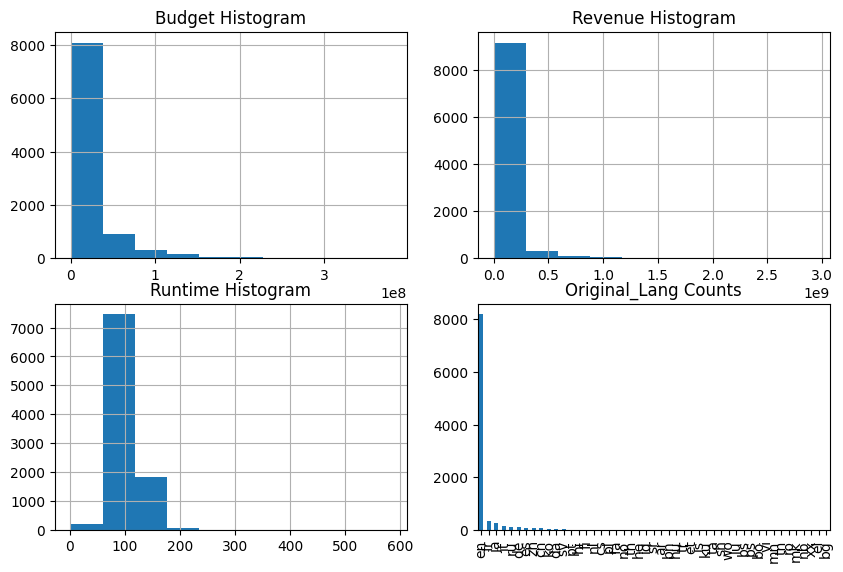

In [41]:
# plotting a few features to get distribution of each

# Set the global default size of matplotlib figures
plt.rc('figure', figsize=(10, 5))

# Size of matplotlib figures that contain subplots
fizsize_with_subplots = (10, 10)

# Size of matplotlib histogram bins
bin_size = 10

# Set up a grid of plots
fig = plt.figure(figsize=fizsize_with_subplots)
fig_dims = (3, 2)


# Plot the Budget histogram
plt.subplot2grid(fig_dims, (0, 0))
full_data['Budget'].hist()
plt.title('Budget Histogram')

# Plot the Budget histogram
plt.subplot2grid(fig_dims, (0, 1))
full_data['Revenue'].hist()
plt.title('Revenue Histogram')

# Plot the Budget histogram
plt.subplot2grid(fig_dims, (1, 0))
full_data['Runtime'].hist()
plt.title('Runtime Histogram')

plt.subplot2grid(fig_dims, (1, 1))
full_data['Original_Lang'].value_counts().plot(kind='bar',
                                       title='Original_Lang Counts')

To get a general idea about the data, we assess distributions of some variables in our data.

- We can see from the graphs above that most of the movies have Budget and Revenue as 0, probably due to lack of information on the TMDB website.

- We can also see that most of the movies are 100 minutes long i.e a little over 1 hour 30 minutes long.

- Most of the movies are in English language.

### Relationship between variables

Splitting the total 12 features into continous numerical and categorical features.

In [42]:
numerical_features = full_data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = full_data.select_dtypes(include=['category', 'object']).columns

print(f"There are {len(numerical_features)} numerical features and {len(categorical_features)} categorical features in the data")

There are 5 numerical features and 7 categorical features in the data


To asses the relationship between continous variables, and how they might influence each other, we create a correlation heatmap of the numerical features.

We also want to asses how the numerical variables correlate to our target, avg_rating.

<Axes: >

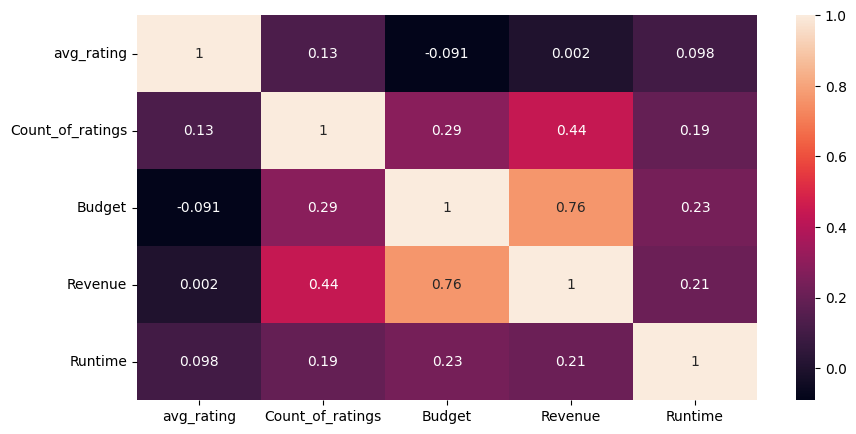

In [43]:
# assessing the numerical features

# correlation heatmap

corr = full_data[numerical_features].corr()
sns.heatmap(corr, annot = True)

From the heatmap we can also see that budget and revenue are highly correlated. Therefore we could say that the revenue generated by a movie is a consequence of the budget of the movie: the higher the budget, the more revenue is generated.

Checking numerical variable correlations with the taget variable: avg_ratings.

In [44]:
corr['avg_rating'].sort_values(ascending=False)

avg_rating          1.000000
Count_of_ratings    0.130091
Runtime             0.098121
Revenue             0.001961
Budget             -0.090717
Name: avg_rating, dtype: float64

We can see that the count of ratings has the highest correlation with avg_rating, followed by runtime, revenue and budget.

### Feature: Actor

Checking top actors in terms of the number of movies

In [45]:
actors_df= pd.concat([full_data['Actor_1'], full_data['Actor_2']])
# Count the number of movies for each actor
actor_counts = actors_df.value_counts().reset_index()
actor_counts.columns = ['Actor', 'Number_of_Movies']
actor_counts.head()

,Actor,Number_of_Movies
0,No Actor,206
1,Robert De Niro,49
2,Nicolas Cage,47
3,Bruce Willis,46
4,Johnny Depp,44


We are getting the 'No Actor' value repeated the most, hence we exclude that and recheck the top 5 actors.

In [46]:
actor_counts = actor_counts.drop(0, axis = 0)
actor_counts.head()

,Actor,Number_of_Movies
1,Robert De Niro,49
2,Nicolas Cage,47
3,Bruce Willis,46
4,Johnny Depp,44
5,Jackie Chan,43


We can see that the maximum number of movies are from Robert De Niro, followed by Nicolas Cage and Bruce Williams.

We analyse the top 5 actors in terms of their ratings, movie revenue generated, etc.

In [47]:
# setting display option to avoid scientific notation in revenue

pd.set_option('display.float_format', '{:.4f}'.format)

In [48]:
top_actors_df = actor_counts.head()['Actor']

actor_stats =[]

for actor in top_actors_df:
    actor_movies = full_data[(full_data['Actor_1'] == actor) | (full_data['Actor_2'] == actor)]

    total_revenue = round(actor_movies['Revenue'].sum())
    avg_rating = actor_movies['avg_rating'].mean()
    # Append results to the actor_stats list
    actor_stats.append({'Actor': actor, 'Total_Revenue': total_revenue, 'Avg_Rating': avg_rating})

# Create a DataFrame from the results
actor_stats_df = pd.DataFrame(actor_stats)
actor_stats_df

,Actor,Total_Revenue,Avg_Rating
0,Robert De Niro,4495251087,3.2886
1,Nicolas Cage,4877089042,2.9908
2,Bruce Willis,6192560993,3.0206
3,Johnny Depp,9192883373,3.2674
4,Jackie Chan,2227203729,3.2550


Next, we find the top actors based on a combination of the total ratings and avg ratings: this would show us a more holistic view of judging top actors.

In [49]:
# creating separate dfs for actor1 and actor2

actor1 = full_data[['Actor_1', 'Count_of_ratings', 'avg_rating']]
actor2 = full_data[['Actor_2', 'Count_of_ratings', 'avg_rating']]

In [50]:
actor1.rename(columns ={'Actor_1':'actor'}, inplace = True)
actor2.rename(columns ={'Actor_2':'actor'}, inplace = True)

In [51]:
actors = pd.concat([actor1, actor2], axis = 0)
actors.head()

,actor,Count_of_ratings,avg_rating
0,Tom Hanks,215.0000,3.9209
1,Robin Williams,110.0000,3.4318
2,Walter Matthau,52.0000,3.2596
3,Whitney Houston,7.0000,2.3571
4,Steve Martin,49.0000,3.0714


In [52]:
actors.groupby(['actor']).agg({'Count_of_ratings': 'sum', 'avg_rating':'mean'}).sort_values(by=['Count_of_ratings','avg_rating'], ascending=False).head()

,Count_of_ratings,avg_rating
actor,,
Tom Hanks,2220.0000,3.3383
Harrison Ford,1981.0000,3.3092
Tom Cruise,1489.0000,3.3830
Bruce Willis,1472.0000,3.0206
Jim Carrey,1206.0000,3.0743


We can see that Tom Hanks, Harrison Ford and Tom Cruise are the top 3 actors from a more holistic point of view, as they are the most successful in terms of both, the avg_ratings and the count of ratings (or number of users who rated them, which can be interpreted as a popularity metric).

We next also find the top 5 actors in terms of purely total revenue generated to see if these actors differ from the top listings we generated early.

In [53]:
unique_actors_df = actors_df.drop_duplicates().reset_index(drop=True)

actor_stats = []

for actor in unique_actors_df:
    # Filter rows where the actor appears in 'Actor_1' or 'Actor_2'
    actor_movies = full_data[(full_data['Actor_1'] == actor) | (full_data['Actor_2'] == actor)]

    # Calculate total revenue and average rating
    total_revenue = actor_movies['Revenue'].sum()

    # Append results to the actor_stats list
    actor_stats.append({'Actor': actor, 'Total_Revenue': total_revenue, 'Avg_Rating': avg_rating})

# Create a DataFrame from the results
actor_stats_df = pd.DataFrame(actor_stats)

# Display the top 5 actors based on total revenue
top_actors_revenue = actor_stats_df.sort_values(by='Total_Revenue', ascending=False).head(5)

print("Top 5 actors based on total revenue:")
print(top_actors_revenue)

Top 5 actors based on total revenue:
                 Actor    Total_Revenue  Avg_Rating
39   Robert Downey Jr. 10271581623.0000      3.2550
185         Tom Cruise 10232342329.0000      3.2550
0            Tom Hanks  9624163713.0000      3.2550
80         Johnny Depp  9192883373.0000      3.2550
6        Harrison Ford  9153077518.0000      3.2550


We an see that the top 5 actors in terms of total revenue are different from the top 5 actors in terms of a combination highest average ratings and total revenue, and even different from actors with the highest number of movies. We see that Harrison Ford, Jonny Depp, Tom Hanks and Tom Cruise are appearing in at least 2 of the 3 actor listings generated.

We also see that Robert Downey Jr. is the actor who's films make the highest revenue, however in terms of ratings and number of movies, he falls behind other actors.

### Feature: Director

We repeat similar steps as above for the Director feature to find the top directors

In [54]:
director_df = full_data['Director']
# Count the number of movies for each actor
director_counts = director_df.value_counts().reset_index()
director_counts.columns = ['Director', 'Number_of_Movies']
director_counts.head()

,Director,Number_of_Movies
0,No Director,627
1,Woody Allen,46
2,Alfred Hitchcock,37
3,Clint Eastwood,31
4,Steven Spielberg,31


In [55]:
director_counts = director_counts.drop(0, axis = 0)
director_counts.head()

,Director,Number_of_Movies
1,Woody Allen,46
2,Alfred Hitchcock,37
3,Clint Eastwood,31
4,Steven Spielberg,31
5,Martin Scorsese,29


We see that Woody Allen, Alfred Hitchcock and Clint Eastwood are the top 3 directors in terms of the number of movies made by them.

In [56]:
top_directors_df = director_counts.head()['Director']

director_stats =[]

for director in top_directors_df:
    director_movies = full_data[(full_data['Director'] == director)]

    total_revenue = round(director_movies['Revenue'].sum())
    avg_rating = director_movies['avg_rating'].mean()
    # Append results to the actor_stats list
    director_stats.append({'Director': director, 'Total_Revenue': total_revenue, 'Avg_Rating': avg_rating})

# Create a DataFrame from the results
director_stats_df = pd.DataFrame(director_stats)
director_stats_df

,Director,Total_Revenue,Avg_Rating
0,Woody Allen,1137505200,3.5148
1,Alfred Hitchcock,240599707,3.6304
2,Clint Eastwood,3222262998,3.3893
3,Steven Spielberg,9904172689,3.5453
4,Martin Scorsese,2177122326,3.6204


In [57]:
directors = full_data[['Director', 'Count_of_ratings', 'avg_rating']]
directors.drop(directors[directors['Director'] == 'No Director'].index, inplace = True)

In [58]:
directors.groupby(['Director']).agg({'Count_of_ratings': 'sum', 'avg_rating':'mean'}).sort_values(by=['Count_of_ratings','avg_rating'], ascending=False).head()

,Count_of_ratings,avg_rating
Director,,
Steven Spielberg,2022.0000,3.5453
Robert Zemeckis,1080.0000,3.3814
James Cameron,960.0000,3.4803
Quentin Tarantino,930.0000,3.8769
Tim Burton,913.0000,3.2196


We can see that Steven Spielberg, Robert Zemeckis and James Cameron are the top 3 actors from a more holistic point of view, as they are the most successful in terms of both, the avg_ratings and the count of ratings (or number of users who rated them, which can be interpreted as a popularity metric).

Interestingly, only Steven Spielberg is common from the above director listing to the top 5 directors based on total number of movies.

### Feature : Year

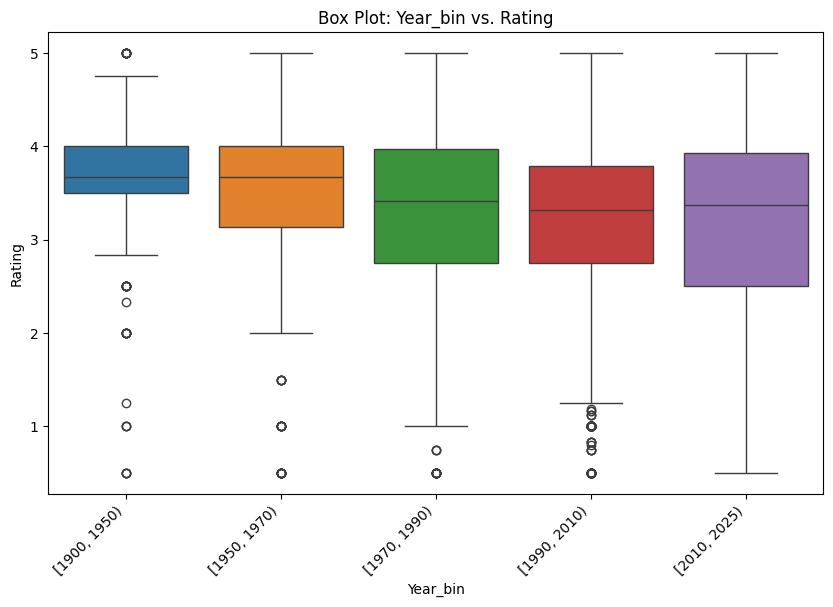

In [59]:
full_data['year'] = full_data['year'].astype(int)
bin_edges = [1900, 1950, 1970, 1990, 2010, 2025]  # Adjust the bin edges as needed
full_data['year_bin'] = pd.cut(full_data['year'], bins=bin_edges, right=False)

# Visualize the distribution of the continuous target variable within each category
#for feature in categorical_features + ['year_bin']:
plt.figure(figsize=(10, 6))
sns.boxplot(x='year_bin', y='avg_rating', data=full_data, palette= 'tab10')
plt.title(f'Box Plot: Year_bin vs. Rating')
plt.xlabel('Year_bin')
plt.ylabel('Rating')
plt.xticks(rotation=45, ha='right')
plt.show()

In earlier years, the distribution of ratings was very concentrated towards higher ratings. As years pass, the ratings have more widely distributed.

### Feature : Genre

In [60]:
genre_1 = genre.astype(int)
genre_1.drop('movieId', axis = 1, inplace = True)
genre_counts = genre_1.sum()
genre_counts.head()

isAdventure    1263
isAnimation     611
isChildren      664
isComedy       3756
isFantasy       779
dtype: int64

We aim to find the popularity of each genre as well as the number of movies made for each genre.

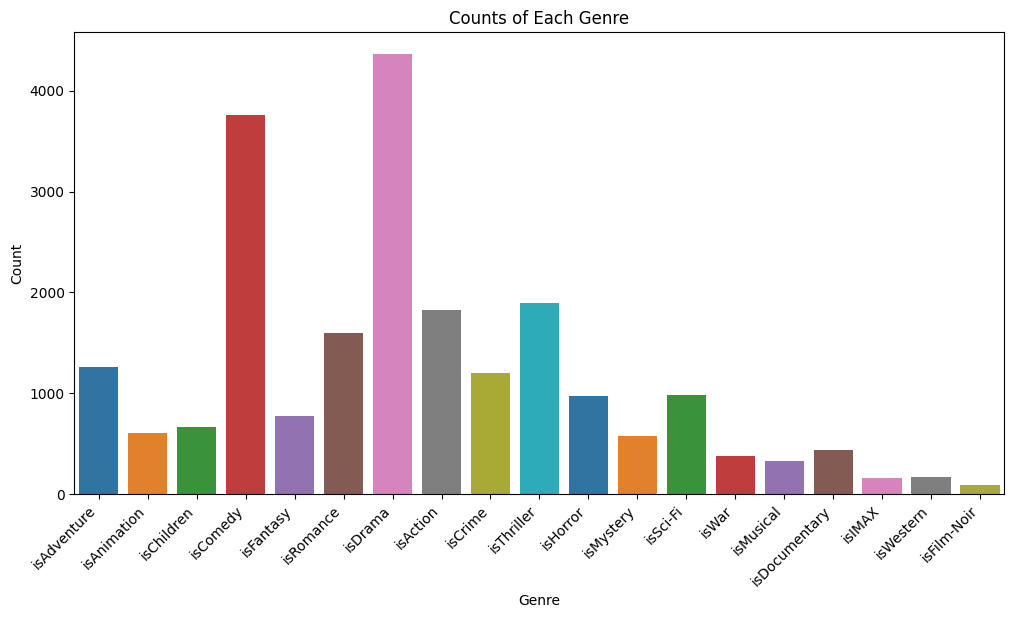

In [61]:
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='tab10')
plt.title('Counts of Each Genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

From the above graph we can see that the highest number of movies made are from the Drama genre, followed by Comedy and Thriller.

We also want to find the ratings based on genre:

### Feature : Ratings
We take Ratings as our target variable while performing linear regression. Here we have taken ratings as the average of the user ratings given in the ratings.csv file.

In [62]:
#Import ratings
# ratings = pd.read_csv('ratings.csv')
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings['year'] = ratings['timestamp'].dt.year
ratings.describe()

,userId,movieId,rating,year
count,100836.0000,100836.0000,100836.0000,100836.0000
mean,326.1276,19435.2957,3.5016,2007.7229
std,182.6185,35530.9872,1.0425,6.8904
min,1.0000,1.0000,0.5000,1996.0000
25%,177.0000,1199.0000,3.0000,2002.0000
50%,325.0000,2991.0000,3.5000,2007.0000
75%,477.0000,8122.0000,4.0000,2015.0000
max,610.0000,193609.0000,5.0000,2018.0000


In [63]:
ratings_per_movie = ratings[['movieId', 'rating']].groupby('movieId').mean()
mean_rating = ratings_per_movie['rating'].mean()

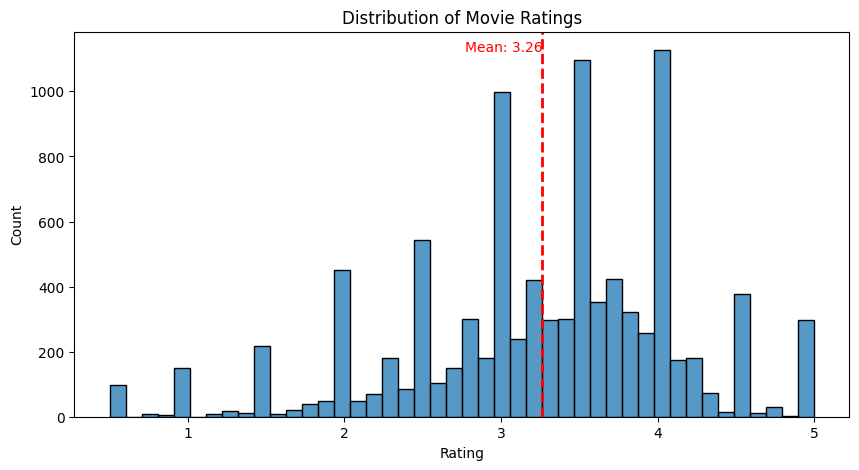

In [64]:
#Plot a simple histogram
sns.histplot(ratings_per_movie, x='rating')
plt.title('Distribution of Movie Ratings')
plt.axvline(mean_rating, color='red', linestyle='dashed', linewidth=2)
plt.text(mean_rating, plt.ylim()[1]*0.95, f'Mean: {mean_rating:.2f}', color='red', ha='right')
plt.xlabel("Rating")
plt.show()

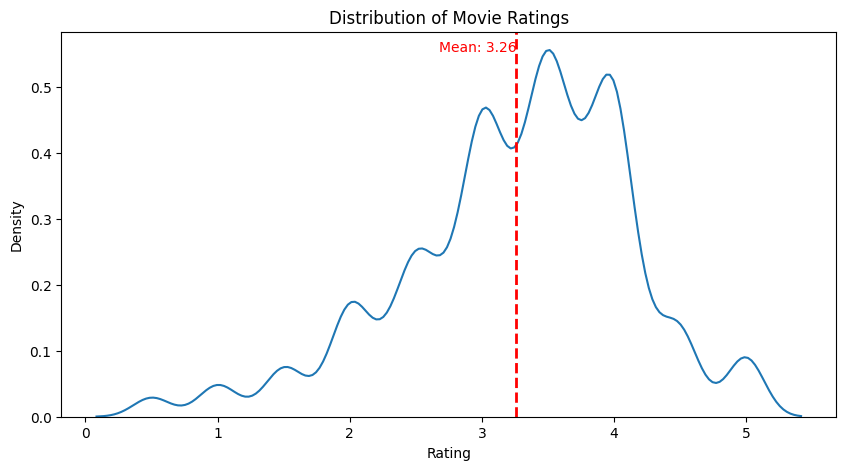

In [65]:
#Apply kde smoothing
sns.kdeplot(ratings_per_movie, x='rating')
plt.title('Distribution of Movie Ratings')
plt.axvline(mean_rating, color='red', linestyle='dashed', linewidth=2)
plt.text(mean_rating, plt.ylim()[1]*0.95, f'Mean: {mean_rating:.2f}', color='red', ha='right')
plt.xlabel("Rating")
plt.show()

Based on the histogram and the estimated density we can see that the distribution of ratings has many peaks due to the fact that users can only give ratings in 0.5 increments. The mean rating is 3.26, which is notably larger than the middle rating that can be given, i.e. 2.5.

In [66]:
#Import genres
#genres = pd.read_csv('genre.csv').iloc[:,1:]
genres = genre
genres.head()

,movieId,isAdventure,isAnimation,isChildren,isComedy,isFantasy,isRomance,isDrama,isAction,isCrime,isThriller,isHorror,isMystery,isSci-Fi,isWar,isMusical,isDocumentary,isIMAX,isWestern,isFilm-Noir
0,1,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,3,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
3,4,False,False,False,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False
4,5,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [67]:
#Get yearly ratings for plotting
yearly_ratings = ratings.drop('userId', axis=1).groupby(['year', 'movieId']).mean()

Text(0, 0.5, 'Rating')

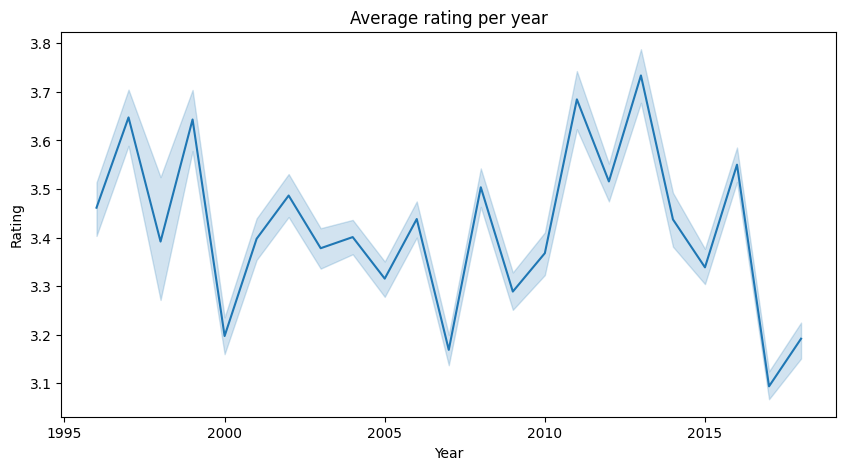

In [68]:
#Plot ratings over the years
sns.lineplot(yearly_ratings, x='year', y='rating')
plt.title("Average rating per year")
plt.xlabel('Year')
plt.ylabel('Rating')

The yearly ratings fluctuate greatly, with the 'best' year being 2013 (mean rating 3.84) and 'worst' year being 2018 (mean rating 2.96)

In [69]:
#Join genres to split the line
yearly_ratings = yearly_ratings.join(genres, on='movieId', how='inner')
yearly_ratings.groupby('year').mean()['rating']

genre_columns = genres.columns.values[1:]

def create_df_for_genre(genre_name: str) -> pd.DataFrame:
    df = yearly_ratings[yearly_ratings[genre_name]]
    df = df.groupby('year').mean()[['rating']]
    df['genre'] = genre_name.lstrip('is')
    return df

yearly_mean_rating_by_genre = pd.concat(map(create_df_for_genre, genre_columns))

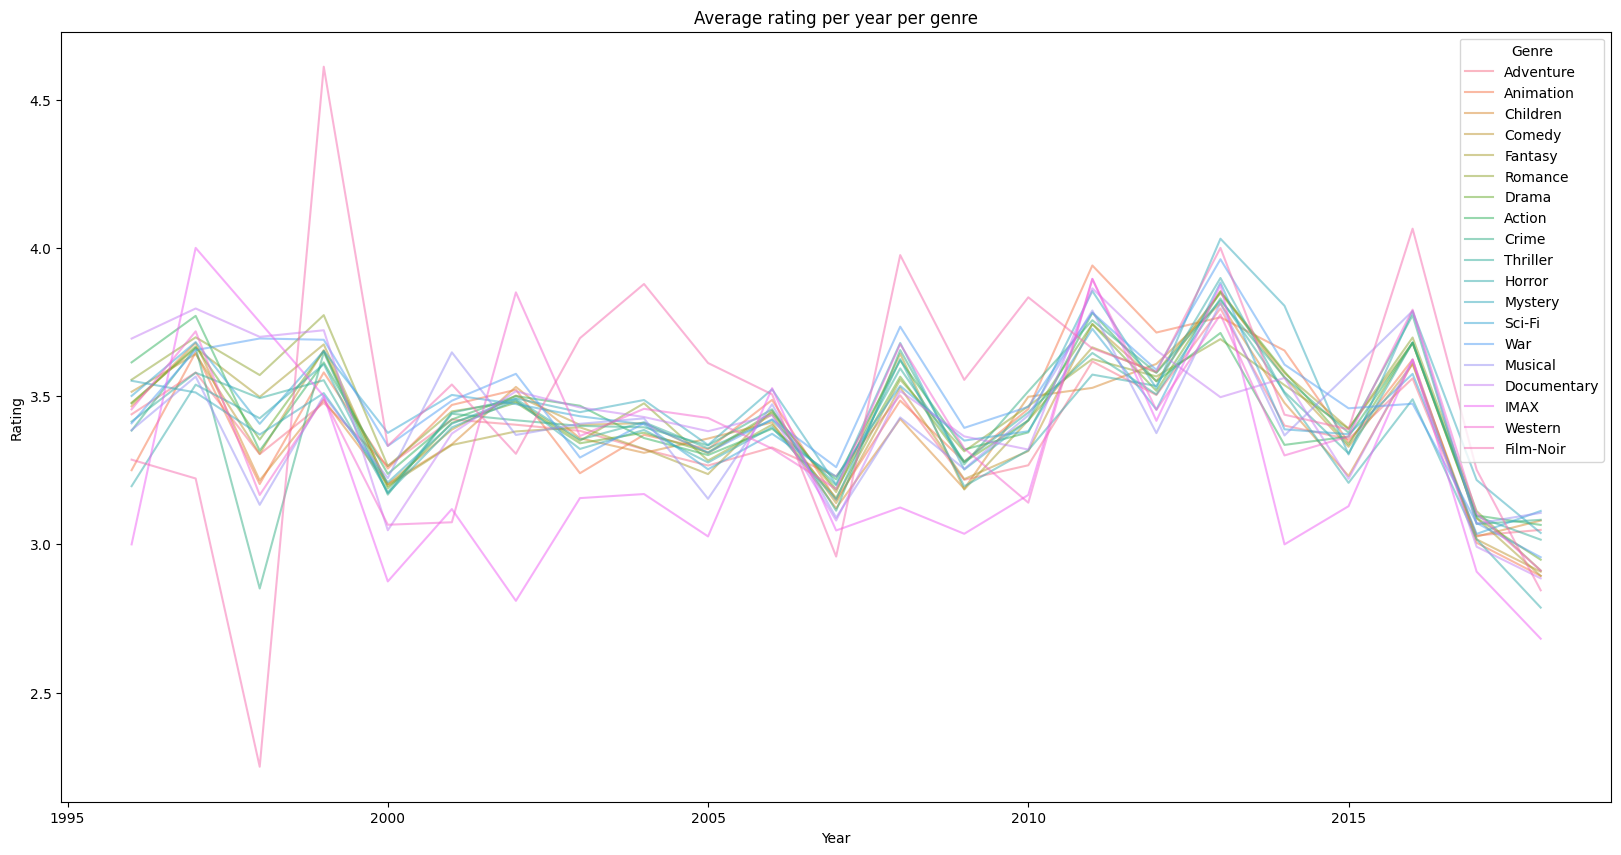

In [70]:
#Same plot as above, but bigger and split by genre
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(yearly_mean_rating_by_genre, x='year', y='rating', hue='genre', alpha=0.5)
plt.title("Average rating per year per genre")
plt.xlabel('Year')
plt.ylabel('Rating')
plt.legend(title="Genre")

Splitting the line by genre does not bring much information as the variability of the ratings is large for all of the genres and most of them achieve similar average ratings.

In [71]:
#Begin preparing the data for regression modelling
movies = final_df_1
movies = movies \
    .join(genres, on='movieId', how='left', rsuffix="r") \
    .drop(['genres', 'Name', 'movieIdr', 'type', 'tmdbId', 'movieId', 'title', 'Actor_1', 'Actor_2',
       'Director'], axis=1) \
    .rename(columns={'userId':'n_reviews'})

movies = movies.loc[(movies['Budget'] != 0.0) & (movies['Revenue'] != 0.0)].dropna()
movies = pd.get_dummies(movies, columns=['Original_Lang'], prefix='og_lang')
movies.columns

Index(['year', 'rating', 'n_reviews', 'Budget', 'Revenue', 'Runtime', 'Adult',
       'isAdventure', 'isAnimation', 'isChildren', 'isComedy', 'isFantasy',
       'isRomance', 'isDrama', 'isAction', 'isCrime', 'isThriller', 'isHorror',
       'isMystery', 'isSci-Fi', 'isWar', 'isMusical', 'isDocumentary',
       'isIMAX', 'isWestern', 'isFilm-Noir', 'og_lang_cn', 'og_lang_cs',
       'og_lang_da', 'og_lang_de', 'og_lang_en', 'og_lang_es', 'og_lang_fa',
       'og_lang_fr', 'og_lang_hi', 'og_lang_it', 'og_lang_iu', 'og_lang_ja',
       'og_lang_ko', 'og_lang_pl', 'og_lang_pt', 'og_lang_ru', 'og_lang_sv',
       'og_lang_ta', 'og_lang_zh'],
      dtype='object')

Text(0.5, 1.01, 'Pairplot of numeric features')

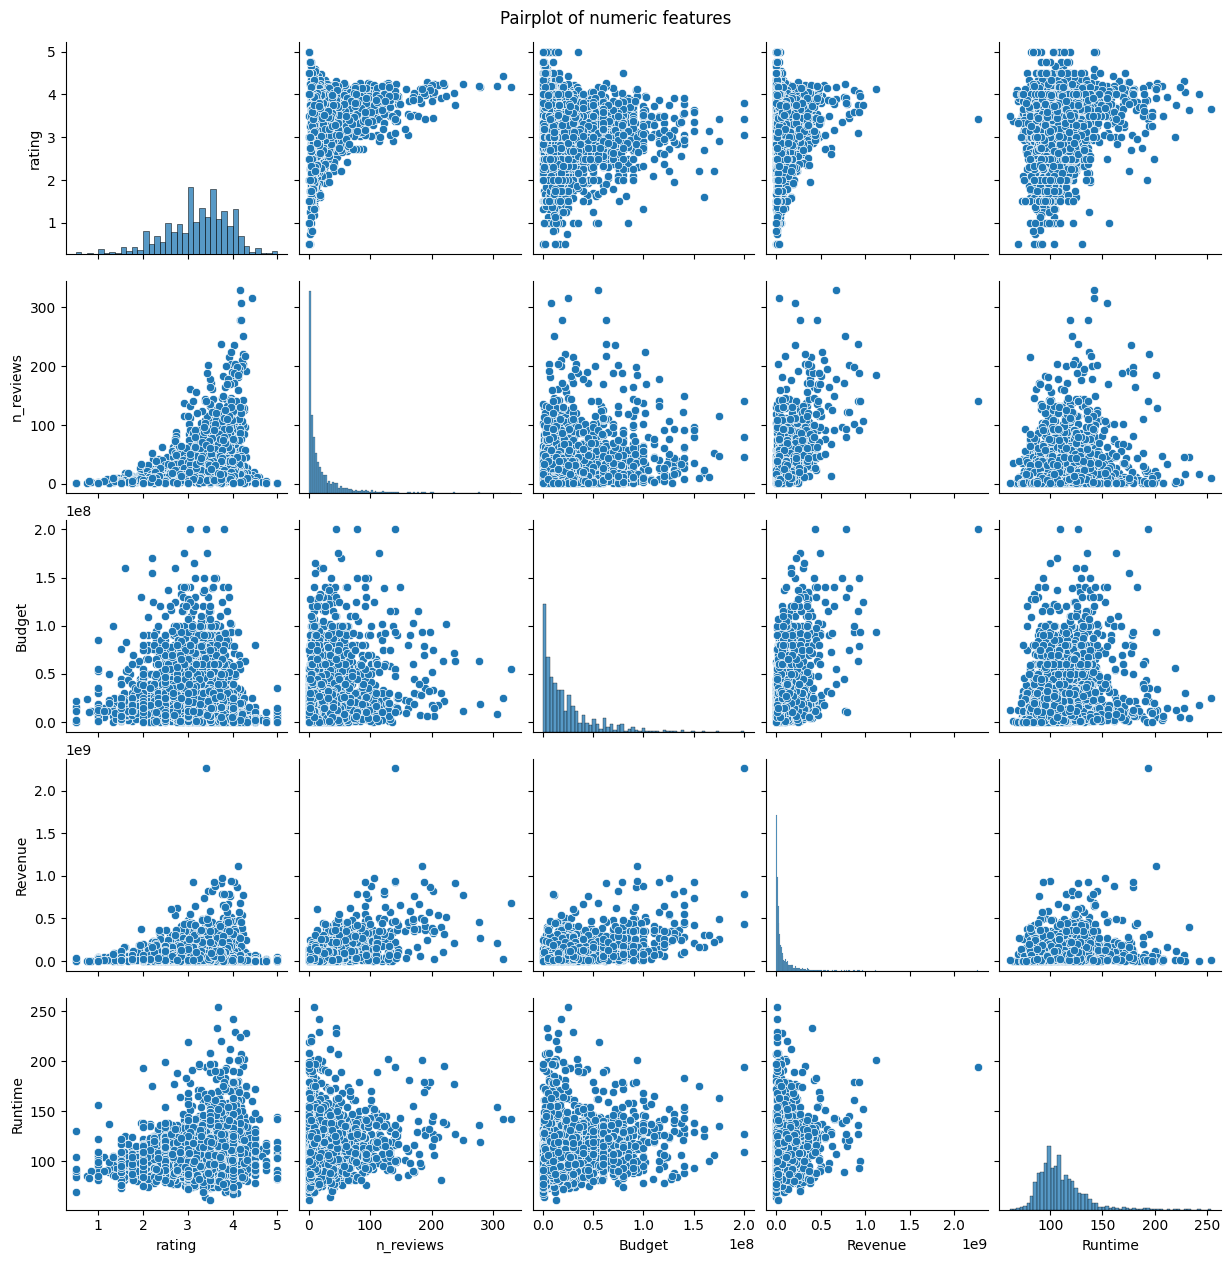

In [72]:
#Get the pairplot to investigate possible correlations
numeric_cols = [col for col in movies.columns if col[0:2] != 'is']
numeric_cols = [col for col in numeric_cols if col[0:2] != 'og']
numeric_cols.remove('Adult')
pp = sns.pairplot(movies[numeric_cols])
pp.fig.suptitle("Pairplot of numeric features", y=1.01)

All four numerical features suggest positive correlation with ratings.

## 6. Data Modelling
## 6.1 Elastic Net
We will now use linear regression with reguralisation to try and predict the rating of a given movie.

In [73]:
#Necessary imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

First, we will split the dataframe into features (X) and the target (y) and covert them to numpy arrays. Then a 70-30 train-validation split is performed, shuffling the data beforehand (as it is currently ordered by release year).

In [74]:
X = movies.drop(['rating'], axis=1).values
y = movies[['rating']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=420, shuffle=True)

Given that we will be employing an elastic net approach that penalises the size of coefficients, standardisation will be necessary. A simple StandarScaler() class from scikit-learn will be used. A variable's standard score is calculated as: $$ z_j=\frac{x_j-\mu_j}{\sigma_j} \forall j=1,...,p$$

In [75]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Elastic net minimises the function: $$ \frac{1}{2 * n_{samples}} * ||y - Xw||^2_2 + \alpha * l1\_ratio * ||w||_1+ 0.5 * \alpha * (1 - l1\_ratio) * ||w||^2_2 $$

Where $$ \alpha \in [0, \infty)  $$
$$l1\_ratio \in [0,1]$$

$\alpha$ multiplies the penalty terms whereas l1_ratio is the mixing parameter (0 for for Lasso and 1 for Ridge Regression). These hyperparameters will be selected as a result of a 10-fold cross-validation procedure on the training set.

In [76]:
param_grid = {
    'alpha' : [0, 0.1, 0.5, 1, 2, 5, 10],
    'l1_ratio' : [0, 0.25, 0.5, 0.75, 1]
}

en = ElasticNet(max_iter=2500)

gs = GridSearchCV(estimator=en, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error')

gs.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, estimator=ElasticNet(max_iter=2500),
             param_grid={'alpha': [0, 0.1, 0.5, 1, 2, 5, 10],
                         'l1_ratio': [0, 0.25, 0.5, 0.75, 1]},
             scoring='neg_mean_squared_error')

In [77]:
gs.best_params_

{'alpha': 0.1, 'l1_ratio': 0.25}

The optimal level of overall regularisation is 0.1, whereas the split between Lasso and Ridge is 1-to-3. We will now try and predict the actual ratings from the test set.

In [78]:
y_pred = gs.best_estimator_.predict(X_test_scaled)

In [79]:
mse = mean_squared_error(y_test, y_pred)
print(mse)

0.3655045397387433


The resulting mean squared error is 0.37. By square-rooting it, we obtain a value of 0.61, meaning that our predictions may be between half a star below or above the true rating. This is a satisfying level of precision given very limited number of both numerical and categorical features. This is a good starting point and a nice way of giving a simple recommendation to a new user with no data to fall back on (overcoming a cold-start problem).

## 7. Recommender System based on Cosine Similarity

Here we use Cosine Similarity to find the similarity between the genres of the movies. We use these values to suggest recommendations to users based on the genres of the movie which they like.

In [80]:
# Libraries Used
import os
import warnings
import numpy as np
import pandas as pd
from math import sqrt
from sklearn.feature_extraction.text import TfidfVectorizer
from itertools import combinations

from sklearn.metrics.pairwise import pairwise_distances,cosine_similarity
warnings.filterwarnings('ignore')
%matplotlib inline


In [114]:
movie_det = final_df_1
movie_final = movie_det[['title', 'Name', 'genres']]
movie_final.head()

,title,Name,genres
0,Toy Story (1995),Toy Story,Adventure|Animation|Children|Comedy|Fantasy
1,Jumanji (1995),Jumanji,Adventure|Children|Fantasy
2,Grumpier Old Men (1995),Grumpier Old Men,Comedy|Romance
3,Waiting to Exhale (1995),Waiting to Exhale,Comedy|Drama|Romance
4,Father of the Bride Part II (1995),Father of the Bride Part II,Comedy


### 7.1 Content Based Filtering

In [115]:
tf = TfidfVectorizer(analyzer=lambda s: (c for i in range(1,4)
                                             for c in combinations(s.split('|'), r=i)))
tfidf_matrix = tf.fit_transform(movie_final['genres'])

pd.DataFrame(tfidf_matrix.todense(), columns=tf.get_feature_names_out(), index=movie_final.title).head()

,"((no genres listed),)","(Action,)","(Action, Adventure)","(Action, Adventure, Animation)","(Action, Adventure, Children)","(Action, Adventure, Comedy)","(Action, Adventure, Crime)","(Action, Adventure, Documentary)","(Action, Adventure, Drama)","(Action, Adventure, Fantasy)",...,"(Thriller,)","(Thriller, IMAX)","(Thriller, War)","(Thriller, Western)","(Thriller, Western, IMAX)","(War,)","(War, IMAX)","(War, Western)","(Western,)","(Western, IMAX)"
title,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Jumanji (1995),0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Grumpier Old Men (1995),0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Waiting to Exhale (1995),0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Father of the Bride Part II (1995),0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


What we have done is -- taken combinations of genres upto 4, i.e if we have "Adventure|Comedy|Action", we are taking combinations like "Adventure", "Comedy", "Action", "Adventure, Comedy", "Comedy, Action" and so on, but in such a way that "Comedy, Action" and "Action, Comedy" are treated the same, since order doesn't matter.

Then we have caculated the TF-IDF weights for each movies using these combinations.

We calculate the similarity between the movies by using the Cosine Similarity

In [116]:
cos_sim = cosine_similarity(tfidf_matrix)

cos_sim_df = pd.DataFrame(cos_sim, index=movie_final['title'], columns=movie_final['title'])
display(cos_sim_df.head())

title,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995),Heat (1995),Sabrina (1995),Tom and Huck (1995),Sudden Death (1995),GoldenEye (1995),...,Gintama: The Movie (2010),anohana: The Flower We Saw That Day - The Movie (2013),Silver Spoon (2014),Love Live! The School Idol Movie (2015),Jon Stewart Has Left the Building (2015),Black Butler: Book of the Atlantic (2017),No Game No Life: Zero (2017),Flint (2017),Bungo Stray Dogs: Dead Apple (2018),Andrew Dice Clay: Dice Rules (1991)
title,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),1.0000,0.4747,0.0334,0.0197,0.0826,0.0000,0.0334,0.2757,0.0000,0.0389,...,0.0900,0.0846,0.0383,0.1592,0.0000,0.3069,0.4871,0.0000,0.0861,0.0826
Jumanji (1995),0.4747,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5807,0.0000,0.0818,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0605,0.0960,0.0000,0.0000,0.0000
Grumpier Old Men (1995),0.0334,0.0000,1.0000,0.5880,0.4049,0.0000,1.0000,0.0000,0.0000,0.0000,...,0.0431,0.0000,0.1879,0.0000,0.0000,0.0432,0.0686,0.0000,0.0000,0.4049
Waiting to Exhale (1995),0.0197,0.0000,0.5880,1.0000,0.2381,0.0000,0.5880,0.0000,0.0000,0.0000,...,0.0254,0.0559,0.5132,0.0000,0.0000,0.0254,0.0404,0.2199,0.0000,0.2381
Father of the Bride Part II (1995),0.0826,0.0000,0.4049,0.2381,1.0000,0.0000,0.4049,0.0000,0.0000,0.0000,...,0.1065,0.0000,0.4640,0.0000,0.0000,0.1068,0.1695,0.0000,0.0000,1.0000


We observe that of the genres are a perfect match -- for example, the genres for Toy Story (1995) obviously perfectly match with itself, the similarity score is 1, and if the genres don't match at all, like genres of Toy Story (1995) dont match with Sudden Death (1995), then the similarity score is 0

We are selecting the first 500 movies to plot a heatmap for the cosine similarity values.

In [86]:
sim_mat_df = cos_sim_df.iloc[:500, :500]

<Axes: xlabel='title', ylabel='title'>

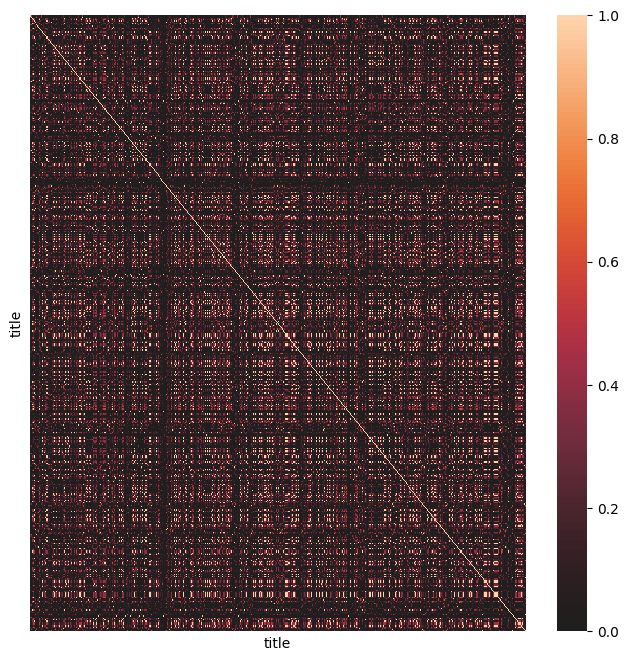

In [87]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize = (8,8))
sns.heatmap(sim_mat_df, center = 0, xticklabels = False, yticklabels = False)

Applying Seriation Method to the Data

In [88]:
sim_mat = sim_mat_df.values
sim_mat
d = sim_mat_df.sum(axis = 1)
D = np.diag(d)
L = D - sim_mat_df

In [89]:
w, v = np.linalg.eigh(L)
eigen_idx = w.argsort()
w = w[eigen_idx] # ordering from smallest to largest
v = v[:,eigen_idx]
fiedler_vector = v[:,1] # selecting the second value

In [90]:
seriation_idx = fiedler_vector.argsort() # seriation index to order rows and columns in Monotonic order of Fiedler Vector elements

In [91]:
col_list = list(sim_mat_df.columns)

In [92]:
new_column_list = []  # ordering columns according to seriation index values
for i in seriation_idx:
    new_column_list.append(col_list[i])

Reordered DataFrame for Rows and Columns in Monotonic order of Fiedler Vector elements

In [107]:
cosine_mat = sim_mat[seriation_idx][:,seriation_idx]
reordered_df = pd.DataFrame(cosine_mat, index = new_column_list, columns = new_column_list)
reordered_df.head()

,Jupiter's Wife (1994),"War Room, The (1993)",Anne Frank Remembered (1995),Man of the Year (1995),Heidi Fleiss: Hollywood Madam (1995),"Wonderful, Horrible Life of Leni Riefenstahl, The (Macht der Bilder: Leni Riefenstahl, Die) (1993)",Crumb (1994),Unzipped (1995),Hoop Dreams (1994),Catwalk (1996),...,"Crow, The (1994)",Unforgettable (1996),From Dusk Till Dawn (1996),"Shadow, The (1994)",Wild Bill (1995),Mary Shelley's Frankenstein (Frankenstein) (1994),"Jungle Book, The (1994)",Desperado (1995),Tales from the Hood (1995),"NeverEnding Story III, The (1994)"
Jupiter's Wife (1994),1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
"War Room, The (1993)",1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Anne Frank Remembered (1995),1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Man of the Year (1995),1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Heidi Fleiss: Hollywood Madam (1995),1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


b) Heatmap for Cosine Similarity Values with Rows and Columns in Monotonic order of Fiedler Vector elements

<Axes: >

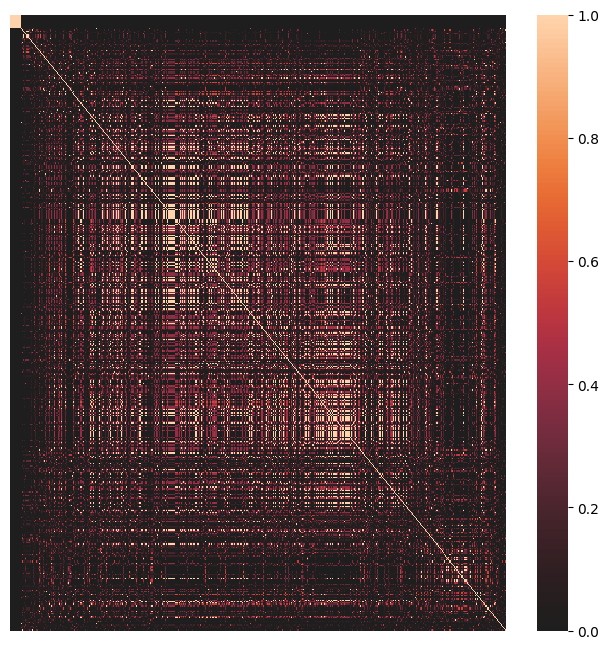

In [95]:
plt.figure(figsize = (8,8))
sns.heatmap(reordered_df, center = 0, xticklabels = False, yticklabels = False)

Now we try to create a Movie Recommender system in which we can input a movie that we like and the number of recommendations we would like to see. The function gets the cosine similarity values for the specified movie and gives us recommendations based on it.

In [96]:
def genre_recommend(movie,n):
    # Get cosine similarity value for the specified movie
    score = pd.DataFrame(cos_sim_df[movie])

    # Sort scores in descending order
    score = score.sort_values(by=movie, ascending = False)

    # Selecting top n movies recommendations
    rec_movies = score.head(n+1)

    # Extracting movie names from the DataFrame
    values = list(rec_movies.index.values)

    # Checks if the specified movie is present in the list of recommended movies and removes it if it exists
    if  movie in values:
        values.remove(movie)

    # To ensure length of recommended movies is n
    if len(values) > n:
        values = values[:n]

    return values

In [109]:
movie_final[movie_final.Name.eq('Aladdin')]

,title,Name,genres
506,Aladdin (1992),Aladdin,Adventure|Animation|Children|Comedy|Musical


In [110]:
rec = genre_recommend('Aladdin (1992)',10)
mov = []
gen = []
for r in rec:
    mov.append(movie_final[movie_final['title']==r]['Name'].values[0])
    gen.append(movie_final[movie_final['title']==r]['genres'].values[0])

df = pd.DataFrame()
df['Movies'] = mov
df["Genres"] = gen
display(df)

,Movies,Genres
0,Robin Hood,Adventure|Animation|Children|Comedy|Musical
1,Oliver & Company,Adventure|Animation|Children|Comedy|Musical
2,Hercules,Adventure|Animation|Children|Comedy|Musical
3,Pete's Dragon,Adventure|Animation|Children|Musical
4,Rock-A-Doodle,Adventure|Animation|Children|Musical
5,Song of the South,Adventure|Animation|Children|Musical
6,The Land Before Time III: The Time of the Grea...,Adventure|Animation|Children|Musical
7,The Muppet Movie,Adventure|Children|Comedy|Musical
8,Muppet Treasure Island,Adventure|Children|Comedy|Musical
9,Shrek 2,Adventure|Animation|Children|Comedy|Musical|Ro...


The recommendation system works well

In [111]:
movie_final[movie_final.Name.eq('Toy Story')]

,title,Name,genres
0,Toy Story (1995),Toy Story,Adventure|Animation|Children|Comedy|Fantasy


In [112]:
rec = genre_recommend('Toy Story (1995)',10)
mov = []
gen = []
for r in rec:
    mov.append(movie_final[movie_final['title']==r]['Name'].values[0])
    gen.append(movie_final[movie_final['title']==r]['genres'].values[0])

df = pd.DataFrame()
df['Movies'] = mov
df["Genres"] = gen
display(df)

,Movies,Genres
0,Asterix and the Vikings,Adventure|Animation|Children|Comedy|Fantasy
1,Toy Story 2,Adventure|Animation|Children|Comedy|Fantasy
2,The Wild,Adventure|Animation|Children|Comedy|Fantasy
3,The Good Dinosaur,Adventure|Animation|Children|Comedy|Fantasy
4,Shrek the Third,Adventure|Animation|Children|Comedy|Fantasy
5,The Adventures of Rocky & Bullwinkle,Adventure|Animation|Children|Comedy|Fantasy
6,Antz,Adventure|Animation|Children|Comedy|Fantasy
7,"Monsters, Inc.",Adventure|Animation|Children|Comedy|Fantasy
8,Turbo,Adventure|Animation|Children|Comedy|Fantasy
9,The Emperor's New Groove,Adventure|Animation|Children|Comedy|Fantasy


## 8. Conclusion

In this exploration of the MovieLens dataset, we embarked on a cinematic journey to understand the factors influencing user ratings and to create a movie recommender system. The research questions helped us analyse different movie genres and their impact on ratings, which helped us discover patterns and insights that transformed our movie nights.

Through data exploration, we also delved into the world of our favorite actors and directors, uncovering insights such as the total number of movies they've contributed to. The exploration also unveiled the highest-grossing actors and directors, giving us a deeper understanding of their prolific contributions to the film industry.

Some of our **key findings** were:

1. *Influence of Movie Genres on User Ratings:*
   - Contrary to preconceived notions, the linear regression model revealed to us that user ratings are not solely determined by a genre. Instead, it's the intersection of genres along with runtime, budget of the movie, the originial language, and the year of release.
   - Our exploration demonstrated that finding the right blend of genres and other factors result in higher ratings, offering a more nuanced perspective on audience preferences.

2. *Recommender System and Cosine Similarity:*
   - The implementation of a recommender system using cosine similarity scores proved to be a powerful tool for providing movie suggestions.
   - By using the connections between movies based on their genre information, the recommender system offered a roadmap to films that resonated with individual tastes.

Our analysis helped us achieve some **objectives**:

1. *Linear Regression Model:*
   - We developed a predictive model based on linear regression to estimate user ratings. This model incorporated various features, and provides with insights into the factors influencing movie ratings.

2. *Recommender System:*
   - We also implemented a recommender system utilising cosine similarity values. This helped us enhance our movie-watching experience by offering recommendations which aligned with all our genre preferences.

**Future Work**:

- The findings from this project can be valuable for streaming platforms, filmmakers, and enthusiasts looking to understand the various factors which drive user preferences.
- Additionally refining the recommender system, incorporating more features and some advanced machine learning techniques can also help build powerful recommender systems in the future.

In conclusion, the exploration of the MovieLens dataset has not only enriched our understanding of movie ratings but has also given us a personalised recommender system, opening new avenues for cinematic exploration and enjoyment. As we bid farewell to the endless debates over movie choices, we welcome a data-driven era of film selection that caters to the diverse tastes of our movie marathon crew.

*Cheers to a new era of movie nights!*